# Environment Setup

---

### Mount Google Drive folder 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Checkout code and model config

In [ ]:
!git clone --branch main https://github.com/hannahg141/ClimateNet.git

Cloning into 'ClimateNet'...
remote: Enumerating objects: 1088, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1088 (delta 191), reused 224 (delta 152), pack-reused 815
Receiving objects: 100% (1088/1088), 16.06 MiB | 38.79 MiB/s, done.
Resolving deltas: 100% (705/705), done.


# Train and evaluate model

Check that GPU is connected.

In [ ]:
import torch

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\nCuda is available: "+str(torch.cuda.is_available()))


!nvcc --version

Fri Dec  9 12:23:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    53W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Move dataset to disk.

In [ ]:
!mkdir /content/Data/
!mkdir /content/Data/train
!mkdir /content/Data/val
!mkdir /content/Data/test

In [ ]:
!cp -r /content/drive/MyDrive/Stanford/CS230/Data/ClimateNet/train/ /content/Data/

In [ ]:
!mv /content/Data/train/*2008* /content/Data/val/
!mv /content/Data/train/*2009* /content/Data/val/
!mv /content/Data/train/*2010* /content/Data/val/

In [ ]:
!cp -r /content/drive/MyDrive/Stanford/CS230/Data/ClimateNet/test/ /content/Data/

Move shell to ClimateNet directory.

In [ ]:
%cd /content/ClimateNet/

/content/ClimateNet


In [ ]:
!git pull

Already up to date.


List models:



In [ ]:
!rm config.json
!ls /content/ClimateNet/


rm: cannot remove 'config.json': No such file or directory
baseline		   data			     image_climatenet.png
climatenet		   example-ablation-PSL.py   models
config-ablation-PSL.json   example-ablation-TMQ.py   print.py
config-ablation-TMQ.json   example-ablation-U850.py  README.md
config-ablation-U850.json  example-ablation-V850.py  train_eval.py
config-ablation-V850.json  example.py


Define training parameters.

In [ ]:
import json

# Create the JSON object for config parameters
config = {
    "architecture": "cgnet",
    "seed": 42,
    "lr": 0.001,
    "train_batch_size": 16,
    "pred_batch_size": 8,
    "epochs": 15,
    "fields": {
        "TMQ": {
            "mean": 19.21859,
            "std": 15.81723
        },
        "U850": {
            "mean": 1.55302,
            "std": 8.29764
        },
        "V850": {
            "mean": 0.25413,
            "std": 6.23163
        },
        "PSL": {
            "mean": 100814.414,
            "std": 1461.2227
        }
    },
    "labels": [
      "Background",
      "Tropical Cyclone",
      "Atmospheric River"
    ],
    "loss": "focal_tversky",
    "scheduler": True,
    "description": "Experiment: CGNet with focal Tversky loss trained on OG ClimateNet with learning rate scheduling."
}

# Write the JSON object to a file in current directory
with open('config.json', 'w') as f:
    json.dump(config, f)

Check training parameters

In [ ]:
cat config.json

{"architecture": "cgnet", "seed": 42, "lr": 0.001, "train_batch_size": 16, "pred_batch_size": 8, "epochs": 15, "fields": {"TMQ": {"mean": 19.21859, "std": 15.81723}, "U850": {"mean": 1.55302, "std": 8.29764}, "V850": {"mean": 0.25413, "std": 6.23163}, "PSL": {"mean": 100814.414, "std": 1461.2227}}, "labels": ["Background", "Tropical Cyclone", "Atmospheric River"], "loss": "focal_tversky", "scheduler": true, "description": "Experiment: CGNet with focal Tversky loss trained on OG ClimateNet with learning rate scheduling."}

Launch training and evaluation script!

In [ ]:
!python3 train_eval.py \
-d /content/Data/ \
-m /content/ClimateNet/


================ Training epoch #1 (cuda:0) ================
Loss: 0.26095 (focal_tversky) | LR: 0.001: 100% 22/22 [00:33<00:00,  1.55s/it]

Training loss: 0.29174 (focal_tversky) 
Classes:      [    BG         TCs        ARs   ]
IoUs:         [0.79038617 0.05397736 0.19736445]  | Mean:  0.3472426578802752
Dice score:   [0.88292256 0.10242603 0.32966479]  | Mean:  0.43833779239332765
Precision:    [0.98098466 0.05891884 0.21086277]
Recall:       [0.80268392 0.39157533 0.75508862]
Specificity:  [0.76029197 0.9726123  0.83048373]
Sensitivity:  [0.80268392 0.39157533 0.75508862]
[[75.376  2.621 15.908]
 [ 0.181  0.171  0.084]
 [ 1.28   0.106  4.273]]

---------- Validation (cuda:0) ----------
100% 7/7 [00:03<00:00,  1.95it/s]

Validation loss: 0.28724 (focal_tversky)
Classes:      [    BG         TCs        ARs   ]
IoUs:         [0.82205551 0.10473914 0.25134027]  | Mean:  0.39271163990451075
Dice score:   [0.9023386  0.18961786 0.40171371]  | Mean:  0.49789005782514445
Precision:    [0.

# Plot training history

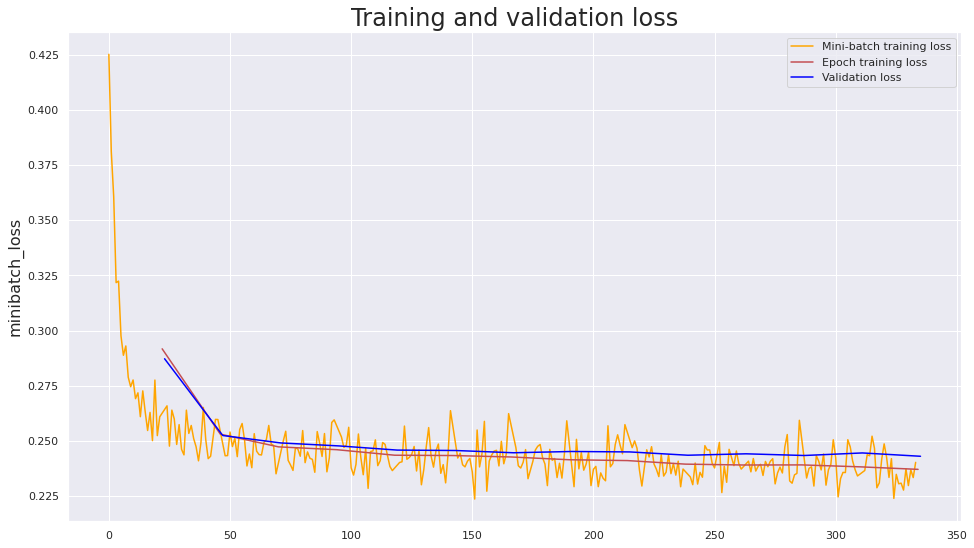

In [ ]:
import seaborn as sns
import pandas as pd

# Open training history as a data frame
df = pd.read_csv('history.csv')

# Create the plot with custom colors for the lines
sns.set(rc = {'figure.figsize' : ( 16, 9 ), 
               'axes.labelsize' : 16, 'axes.titlesize' : 24  })
ax = sns.lineplot(x=range(len(df)), y="minibatch_loss", data=df, label="Mini-batch training loss", color="orange").set(title="Training and validation loss")
ay = sns.lineplot(x=range(len(df)), y="epoch_avg_loss", data=df, label="Epoch training loss", color="r")
az = sns.lineplot(x=range(len(df)), y="epoch_val_loss", data=df, label="Validation loss", color="blue")



# Save model for future evaluation

In [ ]:
!ls -al 

total 4500
drwxr-xr-x 7 root root    4096 Dec  8 15:38 .
drwxr-xr-x 1 root root    4096 Dec  8 15:02 ..
drwxr-xr-x 2 root root    4096 Dec  8 15:01 baseline
drwxr-xr-x 5 root root    4096 Dec  8 15:26 climatenet
-rw-r--r-- 1 root root     600 Dec  8 15:01 config-ablation-PSL.json
-rw-r--r-- 1 root root     603 Dec  8 15:01 config-ablation-TMQ.json
-rw-r--r-- 1 root root     605 Dec  8 15:01 config-ablation-U850.json
-rw-r--r-- 1 root root     605 Dec  8 15:01 config-ablation-V850.json
-rw-r--r-- 1 root root     769 Dec  8 15:54 config.json
drwxr-xr-x 2 root root    4096 Dec  8 15:01 data
-rw-r--r-- 1 root root    1080 Dec  8 15:01 example-ablation-PSL.py
-rw-r--r-- 1 root root    1080 Dec  8 15:01 example-ablation-TMQ.py
-rw-r--r-- 1 root root    1082 Dec  8 15:01 example-ablation-U850.py
-rw-r--r-- 1 root root    1082 Dec  8 15:01 example-ablation-V850.py
-rw-r--r-- 1 root root    1112 Dec  8 15:01 example.py
drwxr-xr-x 8 root root    4096 Dec  8 15:23 .git
-rw-r--r-- 1 root root   35

In [ ]:
!ls '/content/drive/MyDrive/Stanford/CS230/Models'

2022-12-06-001	2022-12-07-004
2022-12-06-002	2022-12-08-01-Baseline
2022-12-06-003	baseline
2022-12-06-004	TMQ-WS850-VRT850-PLS-.001-jl-mb16
2022-12-06-005	TMQ-WS850-VRT850-PLS-PRECT-.0001-jl-mb16
2022-12-06-006	TMQ-WS850-VRT850-PLS-PRECT-.0001-wce
2022-12-07-001	TMQ-WS850-VRT850-PLS-PRECT-.001-jl-mb16
2022-12-07-002	TMQ-WS850-VRT850-PLS-PRECT-.001.wce
2022-12-07-003


In [ ]:
!mkdir /content/drive/MyDrive/Stanford/CS230/Models/2022-12-09-02-FTL/
!cp config.json weights.pth history.csv '/content/drive/MyDrive/Stanford/CS230/Models/2022-12-09-02-FTL'

## Plot Precision-Recall graph for our experiments

(0.0, 1.0)

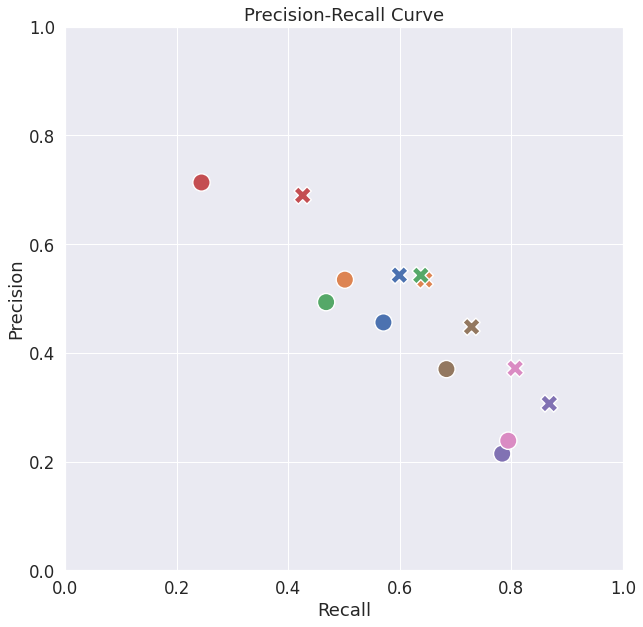

In [ ]:
import pandas as pd
import seaborn as sns

# Create a DataFrame with 4 rows and 2 columns
df = pd.DataFrame({
    'Model': ['1: Baseline', '2: LR scheduler', '3: Feature engineering', '4: Cross entropy loss', '5: Weighted cross entropy', '6: Focal Tversky loss', '7: Weighted IOUs loss', '1: Baseline', '2: LR scheduler', '3: Feature engineering', '4: Cross entropy loss', '5: Weighted cross entropy', '6: Focal Tversky loss', '7: Weighted IOUs loss'],
    'Experiment': ['1', '2', '3', '4', '5', '6', '7', '1', '2', '3', '4', '5', '6', '7'],
    'Weather events': ['Tropical Cyclone','Tropical Cyclone','Tropical Cyclone','Tropical Cyclone','Tropical Cyclone','Tropical Cyclone','Tropical Cyclone','Atmospheric River','Atmospheric River','Atmospheric River','Atmospheric River','Atmospheric River','Atmospheric River','Atmospheric River'],
    'Intersection over union': [0.33955127, 0.3491679, 0.31608774, 0.22278776, 0.20251324, 0.31599551, 0.22453519, 0.39832633, 0.41285328, 0.4146876, 0.35750965, 0.29317686, 0.38387118, 0.34108058],
    'Dice score': [0.5069627, 0.51760482, 0.48034448, 0.36439318, 0.33681665, 0.48023798, 0.36672721, 0.5697187, 0.58442485, 0.58626032, 0.52671397, 0.45342113, 0.55477878, 0.5086653],
    'Precision': [0.45598923, 0.53463995, 0.49327914, 0.71342764, 0.21450748, 0.37011321, 0.23838463, 0.54289729, 0.5343576, 0.54252858, 0.68965182, 0.30685734, 0.44789329, 0.37141691],
    'Recall': [0.57076677, 0.50162175, 0.46807083, 0.24468465, 0.78363352, 0.6836551, 0.79444291, 0.59932803, 0.64484427, 0.63766037, 0.42605401, 0.86800497, 0.72866865, 0.80679887],
    'Specificity': [0.99623709, 0.99758723, 0.99734295, 0.99945687, 0.98414286, 0.9935705, 0.98597405, 0.97010985, 0.96671544, 0.96815083, 0.98864332, 0.88386163, 0.94679579, 0.91912138], 
    'Sensitivity': [0.57076677, 0.50162175, 0.46807083, 0.24468465, 0.78363352, 0.6836551, 0.79444291, 0.59932803, 0.64484427, 0.63766037, 0.42605401, 0.86800497, 0.72866865, 0.80679887]})

# Set the style of the plot to "darkgrid"
sns.set(rc = {'figure.figsize' : ( 10, 10 ), 
               'axes.labelsize' : 20, 'axes.titlesize' : 30})
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5)

# Create the scatter plot with specified colors and a title
ax = sns.scatterplot(y='Precision', x='Recall', s=300, style ='Weather events', hue = 'Model', data=df, legend=False)
ax.set_title("Precision-Recall Curve")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)






(0.0, 1.0)

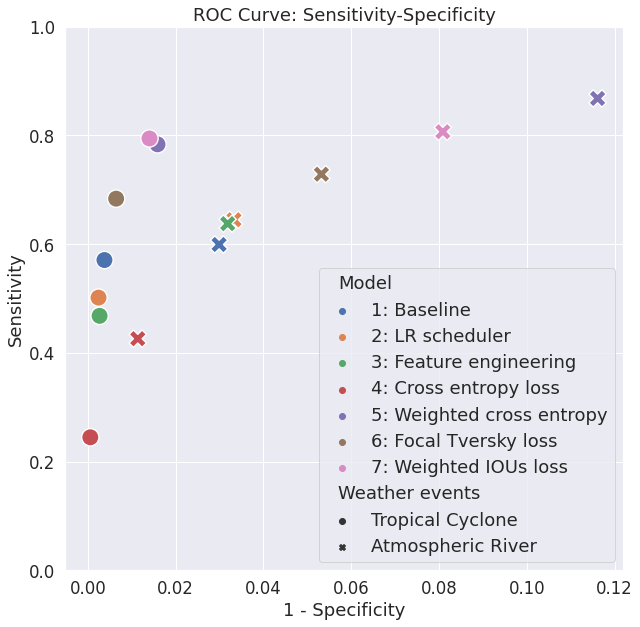

In [ ]:
# Create a DataFrame with 4 rows and 2 columns
df['1 - Specificity'] = 1 - df['Specificity']

# Set the style of the plot to "darkgrid"
sns.set(rc = {'figure.figsize' : ( 10, 10 ), 
               'axes.labelsize' : 20, 'axes.titlesize' : 30})
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5)

# Create the scatter plot with specified colors and a title
ay = sns.scatterplot(y='Sensitivity', x='1 - Specificity', s=300, style ='Weather events', hue = 'Model', data=df, legend=True)
ay.set_title("ROC Curve: Sensitivity-Specificity")
#ay.set_xlim(-0.02, .12)
ay.set_ylim(0, 1)


